# <font style="color:rgb(50,120,229)">Kalman Filtering</font>

# <font style="color:rgb(50,120,229)">Overview</font>

Computer Vision and Machine Learning is not Rocket Science. Or is it? In this lecture, we will learn about a technique called Kalman Filtering that is truly Rocket Science. 

Kalman Filtering was an integral part of the navigation system used by the Apollo program that landed a man on the moon in 1969. In addition, according to Wikipedia,

"Kalman filters have been vital in the implementation of the navigation systems of U.S. Navy nuclear ballistic missile submarines, and in the guidance and navigation systems of cruise missiles such as the U.S. Navy's Tomahawk missile and the U.S. Air Force's Air Launched Cruise Missile. It is also used in the guidance and navigation systems of reusable launch vehicles and the altitude control and navigation systems of spacecraft which dock at the International Space Station."

Kalman Filter ( also called Kalman-Bucy Filter ) was developed by Rudolf E. Kalman and Richard S. Bucy in two papers presented in a mechanical engineering journal in 1960 and 1961. I believe the idea of Kalman Filtering was hanging in the scientific air of the time. If Kalman and Bucy had not developed it, somebody else would have. In fact, physicist Peter Swerling independently invented Kalman Filtering and published it in an astronomy journal one year before Kalman did. 

Kalman Filter is at the heart of every [inertial navigation system](https://en.wikipedia.org/wiki/Inertial_navigation_system). So all commercial flights too use a Kalman Filter in their navigation system. Of course, it is also used in robot navigation and autonomous vehicles. 

In this module, we will learn how to use Kalman Filtering for Object Tracking. 

# <font style="color:rgb(50,120,229)">What is a Kalman Filter?</font>

Understanding Kalman Filter in the abstract can be terrifying, like most other mathematical concepts. So, in this section, we will explain the Kalman Filter using a specific example. 

Imagine you want to build a drone that can fly to a specific location along a specified path. The drone is equipped with a GPS, but of course you cannot rely on the GPS completely for navigations because

1. GPS is accurate only up to a few meters and its accuracy for elevation is even worse. 

2. GPS signal may not be very reliable along the planned path. The drone should be able to go without the GPS signal for sometime. 

So Kalman Filter adopts the following strategy. 

1. **Predict:** Make predictions about the internal state of the system ( e.g. the position and velocity of the drone) based on previous internal state and any control input (e.g. propeller force). 

2. **Update:**  When new measurements ( e.g. GPS information ) about parts of the internal state becomes available, use it to update the prediction made in step one. 

## <font style="color:rgb(50,120,229)">State Transition Equation</font>

We will first understand the **predict** step of the Kalman Filter. 

At any point in the drone’s flight, you want to know its location precisely. Let’s use a simple motion model for the drone’s flight. The location at step $k$ can be predicted using the location at step $k-1$, the velocity recorded at step $k-1$ and the time elapsed in between.  Let’s assume there is no acceleration. 

The following equations describe the motion model. 

$$
\pmb{p_k} = \pmb{p_{k−1}} + \pmb{v_{k−1}} \Delta t   \hspace{5cm} (1)       
$$ 

$$
\pmb{v_{k}} = \pmb{v_{k−1}} \hspace{7cm} (2)
$$

Where, 

$\pmb{p}$ is the 3D position 

$\pmb{v}$ is the 3D velocity vector 

$\Delta t$ is the time elapsed 

The position $\pmb{p_k}$ and velocity $\pmb{v_k}$ together are called the **state** of the system.  Equations (1) and (2) can be combined into one **state transition equation** given by 

$$
\begin{bmatrix}\pmb{p_k} \\ \pmb{v_k}\end{bmatrix} = \pmb{F_k} \begin{bmatrix}\pmb{p_{k−1}} \\ \pmb{v_{k−1}}\end{bmatrix} \hspace{6cm}(3) 
$$ 

The matrix $\pmb{F_k}$ is called the **state transition matrix**. We can expand Equation (3) to see the internal details. 

$$
  \begin{bmatrix}
   x_k \\
   y_k \\
   z_k \\
   u_k \\
   v_k \\
   w_k \\
  \end{bmatrix}=\begin{bmatrix}
   1 & 0 & 0 & \Delta t & 0 & 0\\
   0 & 1 & 0 & 0 & \Delta t & 0\\
   0 & 0 & 1 & 0 & 0 & \Delta t\\
   0 & 0 & 0 & 1 & 0 & 0\\
   0 & 0 & 0 & 0 & 1 & 0\\
   0 & 0 & 0 & 0 & 0 & 1\\
  \end{bmatrix}
  \quad
  \begin{bmatrix}
   x_{k-1} \\
   y_{k-1} \\
   z_{k-1} \\
   u_{k-1} \\
   v_{k-1} \\
   w_{k-1} \\
  \end{bmatrix} \hspace{1cm}(4)
$$  


**<font style="color:rgb(255,0,0)">Note:</font>** Symbols written using a bold font are either a Matrix or a vector. Any symbol written using regular font is a scalar. So, $\pmb{p}=[x,y,z]^T$ is the 3D position and $\pmb{v}=[u,v,w]^T$ is the 3D velocity ( e.g. $u$ is the velocity in the x dimension ). 

As, mentioned earlier, the position and the velocity together form state of the system. Let’s define the state vector as:  $\pmb{x_k} = \begin{bmatrix}\pmb{p_k} \\ \pmb{v_k}\end{bmatrix}$

Now, Equation (3) can be rewritten as 

$$ 
\pmb{x_k} = \pmb{F_k}    \pmb{x_{k−1}} \hspace{9cm}(5)  
$$

## <font style="color:rgb(50,120,229)">Modeling Uncertainties</font>

Even though we can predict the position and velocity, our prediction is probabilistic. There are uncertainties associated with our prediction. 

Uncertainties are usually modeled using a Gaussian distribution with a mean ($\mu$) and a variance ($\delta^2$). Suppose someone asks you to guess the current local time while you are stuck in a boring office job which makes you check your watch ten times in an hour for the lunch break. The current time is the mean. Making a prediction without looking at your watch, you are likely to be off by a few minutes. But since you have been checking your watch quite frequently, your time estimate will have a low variance around the mean. Now, you go out with friends on a Friday night and party hard. Someone asks your the time again. Assuming you are in a position to answer the question, your answer will most likely be off by a larger margin. In other words, your estimate will have a high variance. 

Back to drones. In our case, the state vector has 6 elements -- three for position and three for velocity. In such a case, we can model the uncertainties using a multivariate Gaussian with a 6x1 mean vector  and a 6x6 covariance matrix.  You may be tempted to think why we do not have a 6x1 vector of variances to model uncertainty in each element. The reason is that some of the dimensions may be correlated. For example, the position in the x dimension is correlated to the velocity in the x dimension. The off-diagonal entries of the covariance matrix capture this correlation. 

At any stage, we keep the state vector $\pmb{x_k}$ and the covariance matrix $\pmb{P_k}$ so we not only know what our current prediction is, but also know how certain we can be about our own estimate. 

We know we can use Equation (5) to update $\pmb{x_k}$. How do we update the covariance matrix $\pmb{P_k}$?

**Mathematical Identity**

If the distribution of random variable $\pmb{y}$ has covariance $\pmb{\Sigma}$, then the covariance matrix for random variable $\pmb{Ay}$ is given by $\pmb{A\Sigma A^T}$

Note: $\pmb{A}$ is some arbitrary matrix.


Based on the above identity, $\pmb{P_k}$ has the following update equation. 


$$ 
\pmb{P_k} = \pmb{F_k}    \pmb{P_{k−1}} \pmb{F^T_k} \hspace{7cm}(6)
$$

## <font style="color:rgb(50,120,229)">Control Input</font>

Up until now, we have come up with an equation for predicting the location and velocity of the drone based on previous location and velocity using Equation (5). We have also been able to update the covariance matrix representing uncertainty in our estimates using Equation (6). But that is not the complete story. 

The state of the drone can also be influenced by some control inputs. For example, based on some internal computation done to correct the course, the drone may propel itself in a certain direction. These external controls are modeled using a vector $\pmb{u}$.


$$ 
\pmb{x_k} = \pmb{F_k}    \pmb{x_{k−1}} + \pmb{B_k u_k} \hspace{7cm}(7)
$$

In the above equation, the matrix  $\pmb{B_k}$ is called the control matrix. It illustrates the mechanism by which $\pmb{u_k}$ influences state $\pmb{x_k}$. For example, if $\pmb{u_k}$ is the acceleration vector in 3D and if you remember your equation of motion from high school physics, $\pmb{B_k}$ would look like 


$$
\pmb{B_k} = \begin{bmatrix} \frac{(\Delta t)^2}{2} & 0 & 0 \\ 0 & \frac{(\Delta t)^2}{2}  & 0 \\ 0 & 0 & \frac{(\Delta t)^2}{2} \\ \Delta t & 0 & 0\\ 0 & \Delta t & 0\\ 0 & 0 & \Delta t \end{bmatrix} \hspace{6cm}(8)
$$

## <font style="color:rgb(50,120,229)">Uncontrolled uncertainties</font>

Just to summarize, up until now we have been able to model the state of the system based on 

1. Previous state

2. Known control input

But then there are things that are beyond our control that affect the state of the drone. For example, the drone’s navigation could be affected by a blowing breeze. These uncertainties are modeled as a zero mean Gaussian noise with covariance $\pmb{Q_k}$. So now we can update our equations as follows. 


$$ {\pmb{x_k} = \pmb{F_k}    \pmb{x_{k−1}} + \pmb{B_k u_k} \\
\pmb{P_k} = \pmb{F_k}    \pmb{P_{k−1}} \pmb{F^T_k} + \pmb{Q_k}} \hspace{8cm}(9)
$$


This completes the **prediction step** of the Kalman filter. 

## <font style="color:rgb(50,120,229)">Measurements</font>

Up until now, we have focussed on predicting the state of the system based on previous state and control inputs. We have also tried to incorporate random uncertainties beyond our control. 

We now move onto the **update** step of the Kalman filter. 

Remember our drone also has a GPS that can help us estimate the location. Let’s call it $\pmb{z_k}$. It is a 3D position vector and this estimate too has some uncertainties modeled using a covariance matrix $\pmb{R_k}$. When this information is available, we should combine it without our current estimate from previous sections to come up with a better estimate.

However, the GPS provides only location information, and our state has both location and velocity information. 

No worries! All we need is an **Observation Matrix** ($\pmb{H_k}$) that maps the current state to the observation space ( i.e. the information from the GPS ). So $\pmb{H_kx_k}$ and $\pmb{z_k}$ are quantities you can compare ( i.e. they are in the same space ). In our case, 

$$
\pmb{H_k} = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1  & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 \end{bmatrix}
$$

When we multiply $\pmb{H_k}$ to $\pmb{x_k}$, we are simply keeping the location terms and throwing away the velocity terms. 

The covariance matrix for $\pmb{H_kx_k}$ is simply $\pmb{H_kP_k{H_k}^T}$ ( using the identity discussed above ). 

## <font style="color:rgb(50,120,229)">Fusing information</font>

Before we move forward let’s take a digression to understand information fusion. 

Suppose we have two estimates of a quantity ( say, temperature ) from two different sensors. One sensor estimates the temperature to be $5^o$ F.  But we know this sensor cannot be trusted completely. It is noisy with a standard deviation of 2. The other sensor is slightly more accurate with a standard deviation of 1.5. It is reporting the temperature to be 10o F. 

We have shown the situation graphically below.

<center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m2-fusingTempGraph1.png" width=400/></center>

<center>Figure 1: Two noisy temperature sensors provide two estimates for temperature. The one in blue estimates the temperature to be  $5^o$ F and the red one estimates the temperature to be  $10^o$ F. The lower  of the red sensor implies we trust its estimate more. </center>


Which sensor should we trust? We trust the red sensor more, but that does not mean the blue sensor information is useless. Turns out we can combine the two sources of information by simply multiplying the two Gaussians. 

Figure 2 illustrates the point graphically. The new estimate, shown using the green curve, is slightly toward the red sensor because the red sensor is more accurate than the blue sensor. Also note that the $\sigma$ of the new green curve is lower than $\sigma$s of the other two curves indicating we are more certain about the information after fusing the two information. 

<center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m2-fusingTempGraph.png" width=400/></center>

<center>Figure 2: The information from the blue and the red curve can be combined by simply multiplying the two curves and normalizing so that the area under the green curve sums to one. </center>



Now, let’s get back to our original problem. We have sources of information about the location of the drone. 

1. Prediction $\pmb{H_kx_k}$ with covariance matrix $\pmb{H_kP_k{H_k}^T}$

2. Measurement $\pmb{z_k}$ with covariance matrix $\pmb{R_k}$

We can combine the two sources of information in exactly the same way we did for the temperature sensor in the example above. The only difference is that we now have a multivariate Gaussian distribution and instead of a scalar mean and variance, our distribution is defined by a mean vector and covariance matrix. 

After some mathematical jugglery ( which we will omit ), the best estimate of the state by combining the two pieces of information is given by 

$$
{\pmb{\hat{x}_k} = \pmb{x_k} + \pmb{K} ( \pmb{z_k} − \pmb{H_k x_k} )\\\pmb{\hat{P}_k} = \pmb{P_k}  − \pmb{K H_k P_k}} \hspace{7cm}(10) 
$$


Where, 

$$
\pmb{K} = \pmb{P_k H^T_k} (\pmb{H_k P_k H^T_k} + \pmb{R_k})^{−1} \hspace{6cm}(11)
$$

## <font style="color:rgb(50,120,229)">Summary</font>

The Kalman filter is a method for tracking the internal state of the system based on internal dynamics and control inputs while fusing independent measurements of the state. It has two steps :

1. **Predict**: A prediction is made based on internal dynamics and control inputs. See Equation (9). 

2. **Update** : An update is made to the prediction based on independent measurements. Shown in Equation (10).

## <font style="color:rgb(50,120,229)">Code and Tutorial</font>

The **KalmanFilter** class in OpenCV implements the Kalman filter. In the tutorial below, we will use Kalman Filtering to track a person walking. We first detect the person using a HOG based person detector. We then initialize a Kalman filter to track the the top left corner (x, y) and the width (w) of the bounding box. We use a simple motion model where x, y and w have velocities but no acceleration. Consequently, our state has 6 elements ( x, y, w, vx, vy, vw ) and the measurement has 3 elements ( x, y, w ). There are no control inputs because in a recorded video we have not way to influence the motion of the object. 

In [2]:
import os
import sys 
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## <font style="color:rgb(50,120,229)">Function to detect the rectangle with the maximum area</font>

In [4]:
# To detect max face area in multiple array of faces(x,y,w,h) 
def maxRectArea(rects):
  area = 0
  maxRect = rects[0].copy()
  for rect in rects:
    x, y, w, h = rect.ravel()
    if w*h > area:
      area = w*h
      maxRect = rect.copy()
  maxRect = maxRect[:, np.newaxis]
  return maxRect

## <font style="color:rgb(50,120,229)">Initialize hog descriptor for people detection</font>

In [5]:
# Initialize hog descriptor for people detection
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(winSize, blockSize, 
                      blockStride,cellSize, 
                      nbins, derivAperture,
                      winSigma, histogramNormType, 
                      L2HysThreshold,gammaCorrection, 
                      nlevels, signedGradient)

svmDetector = cv2.HOGDescriptor_getDefaultPeopleDetector()
hog.setSVMDetector(svmDetector)
#  Load video
cap = cv2.VideoCapture(DATA_PATH + "videos/boy-walking.mp4")

# Confirm video is open
if not cap.isOpened():
    print("Unable to read video")

# Variable for storing frames
frameDisplay = []

In [6]:
blue = (255, 0, 0)
red = (0, 0, 255)

## <font style="color:rgb(50,120,229)">Initialize Kalman filter. </font>

OpenCV Kalman filter is initialized using

```python
KalmanFilter KF(numStateVariables, numMeasurements, numControlInputs, type);
```
In our Kalman filter, the state consists of 6 elements `(x, y, w, vx, vy, vw)` of the bounding box where, 

**x, y** = Coordinates of the top left corner of the box

**w** = Width of the detected object

**vx, vy** = x and y velocities of top left corner of the box. 

**vw** = rate of change of width with respect to time. 

*The height is not part of the state because height is always twice the width.*

Hence, `numStateVariables = 6.`

The `measurement matrix` has 3 elements `(x, y, w)` which are simply the x and y coordinates of the top left corner of the detected object and the width of the object. 

Hence `numMeasurements = 3`

There are no controlInputs because this is a recorded video and there is no way for us to change the affect the state of the person walking. 

The type is set to float32

In [7]:
# Internal state has 6 elements (x, y, width, vx, vy, vw)
# Measurement has 3 elements (x, y, width ).
# Note: Height = 2 x width, so it is not part of the state
# or measurement.
KF = cv2.KalmanFilter(6, 3, 0)

## <font style="color:rgb(50,120,229)">Motion Model and Transition Matrix </font>
Because our motion model is 

$$x = x + vx * dt$$
  
$$y = y + vy * dt$$
  
$$w = y + vw * dt$$


For simplicity, we assume zero accelaration. Therefore, 

$$vx = vx$$
  
$$vy = vy$$
 
$$vw = vw$$


Therefore, the transition matrix is of the form


 $$
\begin{bmatrix} 1 & 0 & 0 & dt & 0 & 0 \\ 0 & 1 & 0 & 0 & dt & 0 \\ 0 & 0 & 1 & 0 & 0 & dt \\ 0 & 0 & 0 & 1 & 0 & 0 
\\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$



We set it to identity and later add $dt$ in a loop. 

In [8]:
KF.transitionMatrix = cv2.setIdentity(KF.transitionMatrix)

Measurement matrix is of the form

 $$
\begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0
\end{bmatrix}
$$



because we are only detecting $x$, $y$ and $w$. The measurement matrix picks those quantities and leaves $vx$, $vy$, $vw$.

In [9]:
KF.measurementMatrix = cv2.setIdentity(KF.measurementMatrix)

## <font style="color:rgb(50,120,229)">Initializing variables to be used for tracking and bookkeeping</font>

In [10]:
# Variable to store detected x, y and w
measurement = np.zeros((3, 1), dtype=np.float32)
# Variables to store detected object and tracked object
objectTracked = np.zeros((4, 1), dtype=np.float32)
objectDetected = np.zeros((4, 1), dtype=np.float32)

# Variables to store results of the predict and update 
# (a.k.a correct step).
updatedMeasurement = np.zeros((3, 1), dtype=np.float32)
predictedMeasurement = np.zeros((6, 1), dtype=np.float32)

# Variable to indicate measurement was updated
measurementWasUpdated = False

# Timing variable
ticks = 0
preTicks = 0

## <font style="color:rgb(50,120,229)">Read frames until object is detected for the first time</font>

In [11]:
success=True
while success:
    sucess, frame = cap.read()
    objects, weights = hog.detectMultiScale(frame, winStride=(8, 8), padding=(32, 32),
                                        scale=1.05, hitThreshold=0, finalThreshold=1,
                                        useMeanshiftGrouping=False)

    # Update timer
    ticks = cv2.getTickCount()

    if len(objects) > 0:
        # Copying max face area values to Kalman Filter
        objectDetected = maxRectArea(objects)
        measurement = objectDetected[:3].astype(np.float32)

        # Update state. Note x, y, w are set to measured values.
        # vx = vy = vw because we have no idea about the velocities yet.
        KF.statePost[0:3, 0] = measurement[:, 0]
        KF.statePost[3:6] = 0.0

        # Set diagonal values for covariance matrices.
        # processNoiseCov is Q
        KF.processNoiseCov = cv2.setIdentity(KF.processNoiseCov, (1e-2))
        KF.measurementNoiseCov = cv2.setIdentity(KF.measurementNoiseCov, (1e-2))
        break

## <font style="color:rgb(50,120,229)">Apply Kalman Filter</font>

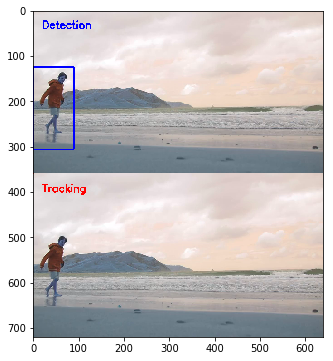

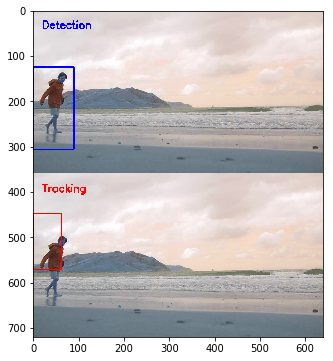

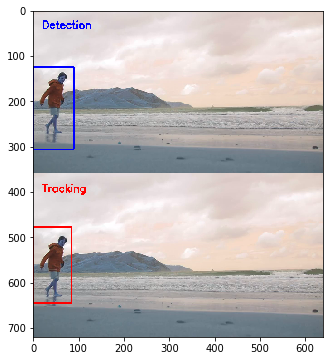

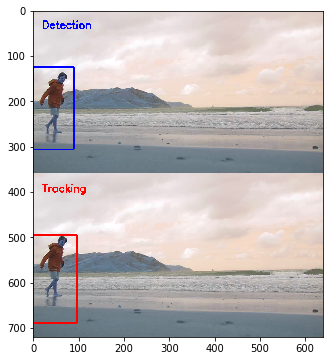

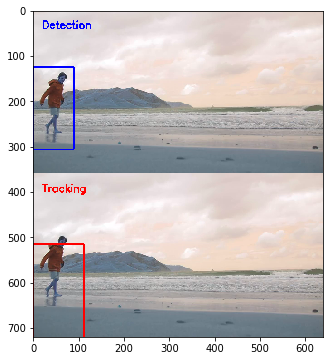

In [12]:
# dt for Transition matrix
dt = 0.0
# Random number generator for randomly selecting frames for update
random.seed(42)

# Loop over rest of the frames
# We will display output for only first 5 frames
count = 0
while True:
    success, frame = cap.read()
    if not success:
        break

    # Variable for displaying tracking result
    frameDisplay = frame.copy()
    # Variable for displaying detection result
    frameDisplayDetection = frame.copy()

    # Update dt for transition matrix.
    # dt = time elapsed.
    preTicks = ticks;
    ticks = cv2.getTickCount()
    dt = (ticks - preTicks) / cv2.getTickFrequency()

    KF.transitionMatrix[0, 3] = dt
    KF.transitionMatrix[1, 4] = dt
    KF.transitionMatrix[2, 5] = dt

    predictedMeasurement = KF.predict()

    # Detect objects in current frame
    objects, weights = hog.detectMultiScale(frame, winStride=(8, 8), padding=(32, 32),
                                            scale=1.05, hitThreshold=0, finalThreshold=1,
                                            useMeanshiftGrouping=False)
    if len(objects) > 0:
        # Find largest object
        objectDetected = maxRectArea(objects)

        # Display detected rectangle
        x1, y1, w1, h1 = objectDetected.ravel()
        cv2.rectangle(frameDisplayDetection, (x1, y1), (x1+w1, y1+h1), red, 2, 4)

    # We will update measurements 15% of the time.
    # Frames are randomly chosen.
    update = random.randint(0, 100) < 15

    if update:
        # Kalman filter update step
        if len(objects) > 0:
            # Copy x, y, w from the detected rectangle
            measurement = objectDetected[0:3].astype(np.float32)

            # Perform Kalman update step
            updatedMeasurement = KF.correct(measurement)
            measurementWasUpdated = True
        else:
            # Measurement not updated because no object detected
            measurementWasUpdated = False
    else:
        # Measurement not updated
        measurementWasUpdated = False

    if measurementWasUpdated:
        # Use updated measurement if measurement was updated
        objectTracked[0:3, 0] = updatedMeasurement[0:3, 0].astype(np.int32)
        objectTracked[3, 0] = 2*updatedMeasurement[2, 0].astype(np.int32)
    else:
        # If measurement was not updated, use predicted values.
        objectTracked[0:3, 0] = predictedMeasurement[0:3, 0].astype(np.int32)
        objectTracked[3, 0] = 2*predictedMeasurement[2, 0].astype(np.int32)

    # Draw tracked object
    x2, y2, w2, h2 = objectTracked.ravel()
    cv2.rectangle(frameDisplay, (x2, y2), (x2+w2, y2+h2), blue, 2, 4)

    # Text indicating Tracking or Detection.
    cv2.putText(frameDisplay, "Tracking", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, blue, 2)
    cv2.putText(frameDisplayDetection, "Detection", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, red, 2)

    # Concatenate detected result and tracked result vertically
    output = np.concatenate((frameDisplayDetection, frameDisplay), axis=0)

    # Display result.
    plt.imshow(output)
    plt.show()
    count += 1
    if count == 5:
        break

In [13]:
cap.release()

## <font style="color:rgb(50,120,229)">Results</font>

First, note the tracking results are much smoother than the detection results. In other words, noise in tracked motion is less than noise in repeated detection. Hence, the name Kalman “Filtering” where the noise is filtered out.

Second, the quality of tracking depends on the uncertainty in motion. If the motion is according to our motion model, tracking will produce very good results. However, if the object changes direction abruptly, prediction will be off until the update step is used.

Finally, Kalman filtering shown in this tutorial does not use pixel information at all for tracking. Can the results be improved if we use pixel information in addition to motion information? Of course, and that is exactly what we will learn in trackers in the next few sections.

# <font style="color:rgb(50,120,229)">References and Further Reading</font>

1. [https://medium.com/self-driving-cars/all-about-kalman-filters-8924abe3aa88](https://medium.com/self-driving-cars/all-about-kalman-filters-8924abe3aa88)

2. [https://www.researchgate.net/publication/224138621_Applications_of_Kalman_Filtering_in_Aerospace_1960_to_the_Present_Historical_Perspectives](https://www.researchgate.net/publication/224138621_Applications_of_Kalman_Filtering_in_Aerospace_1960_to_the_Present_Historical_Perspectives)

3. [http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)

4. [Video Credit](https://www.videvo.net/video/young-boy-walking-along-windy-beach/5816/) ( Licensed under "Videvo Attribution License" from [videvo.net.  Author: Kiril Dobrev](https://www.videvo.net/profile/Kiril%20Videvo)). 